# DocuSort

To begin, we need to import the libraries we need for our task. We'll use Keras to build and train our model and matplotlib to plot our model performance, and we'll use numpy for the rest.

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [3]:
import pandas 
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
%matplotlib inline

## The Dataset
    
Our dataset for this problem is a subset of the RVL-CDIP (Ryerson Vision Lab Complex Document Information Processing) dataset. The original dataset consisted of 400,000 grayscale images in 16 classes (shown below), with 25,000 images per class, and for our subset, we used only 1,250 of these images, which were chosen at random. Then, we created a file that contained all of the corresponding labels. We chose to use a small subset of this massive dataset because of storage constraints, and it made reading in the data much simpler since the images in the original dataset were scattered between multiple folders. Because we chose the images to use at random, there was added bias due to some classes being underrepresented in the training data but being overrepresented in the testing data.

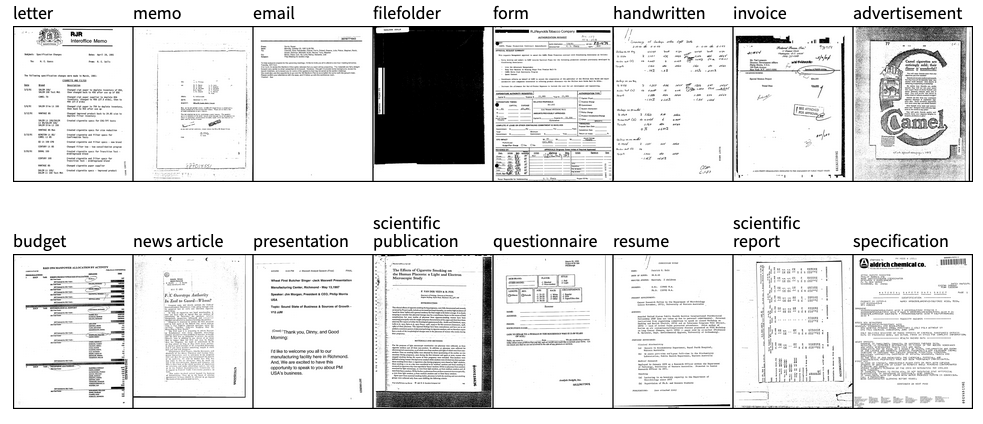

### Reading in the Data

In order to read in the data, you need to put the folder containing the images (Project_images)and the file containing the data labels (Project_labels) in the same folder as the demo iPython notebook. This is important because, in order to read in the image data, we use the path to the individual images to grab each one. Once every image has been loaded, we're left with a 4D tensor that we will be using as input for our networks. The first dimension represents the number of images that we read in (1250), while our second and third dimensions represent the size of the image being loaded in. In this case, the size of the images is 224×224 pixels, and although the images in our dataset are black and white, the network we're using for transfer learning (VGG16) requires that the input images are read in as RBG. Therefore, our fourth dimension is 3 to read in the three color channels (red, blue, and green).

In [4]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) 
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Grab training images
image_data = np.concatenate( 
    [grab_image('Project_images/image%d.tif'%(i))
    for i in range(1,1251)]) 
image_data.shape

(1250, 224, 224, 3)

In [5]:
# Split image data into training and testing sets (84%, 16%)
x_train = image_data[0:1050]
x_test = image_data[1050:1250]

print("x_train:",x_train.shape)
print("x_test",x_test.shape)

x_train: (1050, 224, 224, 3)
x_test (200, 224, 224, 3)


For the data labels, we load the .csv file into our program as an array using numpy's loadtxt function. Then, we convert the class vector (contains classes 0-15) to categorical assignments.

In [6]:
# Read in data labels
label_data = np.loadtxt('Project_labels.csv')

# One-hot encode class vector [0-15] 
label_data = keras.utils.to_categorical(label_data)
display(label_data.shape)
display(label_data[0:10])

(1250, 16)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [7]:
# Split label data into training and testing sets (84% 16%)
y_train = label_data[0:1050]
y_test = label_data[1050:1250]
print("y_train:",y_train.shape)
print("y_test",y_test.shape)

y_train: (1050, 16)
y_test (200, 16)


In [8]:
## Standardize the -input- data between [-1.0,1.0] (real)
## instead of the default 0-255 (integer)
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(1050, 224, 224, 3)

(1050, 16)

(200, 224, 224, 3)

(200, 16)

## Simple CNN
We decided to use our smaller dataset as an opportunity to test the efficacy of applying transfer learning to a convolution neural network (CNN). Our network architecture was inspired by the work of Ryerson University. First, we created a simple CNN in order to test its performance on our small dataset. Then, applied transfer learning to a CNN, and we gathered data about its performance in order to compare it with that of the simple CNN. We anticipated that the transfer learning would yield greater training and testing accuracy than the simple CNN by itself. However, we didn't expect either of our two models to perform better than those used in the Ryerson University study, which were trained on the full RVL-CDIP dataset. 

The simple CNN model used in the Ryerson University study included two convolutional layers and threefully-connected layers, with  pooling, ReLU, and drop-out, which was similar to the simple network that we built. However, their network took in images of size 150×150 as input, while our network took them in as size 224×224. 

### CNNs for Image Classification
When you see a picture of a cat, how do you know it's a cat? In the image, you might recognize there's a cat because you notice its key features: tall, pointy ears, a long tail, etc. Identifying key features of an image is what allows you to classify it, and CNNs achieve this in a similar manner. Images are read into the computer as pixels, and in order to preserve the spatial relationship of those pixels, CNNs read in image data as 2D tensors rather than trying to flatten the representation of the image into a one dimensional tensor. Then, they use kernels to scan patches of the image in order to identify where specific features might be present. After that, the network uses pooling to actually detect those feautures regardless of where they appear in the image, which eliminates translational variance. 

### Training the Model
This model is _large_ (over 8 million parameters!). Therefore, training takes about 30 minutes because each epoch takes about 3 minutes. Similarly, the second model that uses transfer learning is large and will require approximately 10 minutes per epoch.

In [9]:
# Build model
model=keras.Sequential()

model.add(keras.layers.Conv2D(36,kernel_size=(6,6),
                              activation='relu',input_shape=[x_train.shape[1],
                                                             x_train.shape[2],
                                                             x_train.shape[3]]))
model.add(keras.layers.Conv2D(40,(6,6),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(40,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(y_train.shape[1],activation='softmax'))

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 219, 219, 36)      3924      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 214, 214, 40)      51880     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 107, 40)      0         
_________________________________________________________________
dropout (Dropout)            (None, 107, 107, 40)      0         
_________________________________________________________________
flatten (Flatten)            (None, 457960)            0         
_________________________________________________________________
dense (Dense)                (None, 40)                18318440  
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0

In [10]:
#Train model
batch_size = 20
epochs = 10
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.2)

Epoch 1/10
42/42 [==============================] - 172s 4s/step - loss: 5.4399 - categorical_accuracy: 0.0827 - val_loss: 2.7569 - val_categorical_accuracy: 0.1476
Epoch 2/10
42/42 [==============================] - 173s 4s/step - loss: 2.7205 - categorical_accuracy: 0.1389 - val_loss: 2.7023 - val_categorical_accuracy: 0.1381
Epoch 3/10
42/42 [==============================] - 167s 4s/step - loss: 2.5384 - categorical_accuracy: 0.2150 - val_loss: 2.7015 - val_categorical_accuracy: 0.1095
Epoch 4/10
42/42 [==============================] - 168s 4s/step - loss: 2.3056 - categorical_accuracy: 0.2871 - val_loss: 2.6987 - val_categorical_accuracy: 0.1190
Epoch 5/10
42/42 [==============================] - 179s 4s/step - loss: 2.0331 - categorical_accuracy: 0.3741 - val_loss: 2.7390 - val_categorical_accuracy: 0.1476
Epoch 6/10
42/42 [==============================] - 170s 4s/step - loss: 1.7188 - categorical_accuracy: 0.4610 - val_loss: 3.0541 - val_categorical_accuracy: 0.1381
Epoch 7/10

In [11]:
# Testing
results = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

7/7 [==============================] - 4s 563ms/step - loss: 4.8096 - categorical_accuracy: 0.0550
Test loss: 4.809577465057373
Test accuracy: 0.054999999701976776


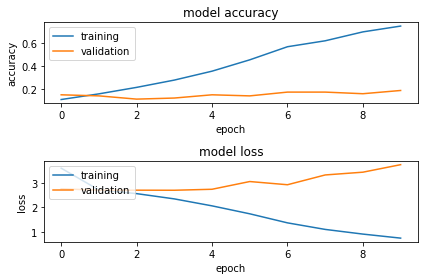

In [22]:
plt.figure()

# Summarize history for accuracy  
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper left')

# Summarize history for loss  
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper left')
plt.tight_layout()
plt.show()

After training, we can see that the model experienced _extreme_ levels of overfitting, meaning the network memorized the training data and was unable to generalize when it was presented with images it had never seen before. Therefore, the network performed poorly on the validation and testing datasets. 

## CNN with Transfer Learning
Although CNNs are ideal for image classification, they can only perform as well as the weights they're initialized with. The simple CNN we built previously had randomly initialized weights, meaning the quality of the weights will vary. But, if we were to apply transfer learning by using a larger model that's been trained on a larger dataset to solve similar problem, the CNN would perform better for our specific problem, depite our network being trained on a small dataset.

### VGG16 Model
The VGG16 Model is a high-performace, pre-trained model that was developed for image recognition tasks.

In [13]:
# Load the VGG16 model
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
# Use the VGG16 model as a base and add our own layers onto the bottom of it
base_model = vgg16

new_model = base_model.output
new_model=keras.layers.GlobalAveragePooling2D()(new_model)
new_model=keras.layers.Dense(30,activation='relu')(new_model)
new_model=keras.layers.Dense(16,activation='softmax')(new_model)
model=keras.Model(inputs=base_model.input,outputs=new_model)

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
#Train model
batch_size = 20
epochs = 10
history2 = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_split = 0.2)

Epoch 1/10
42/42 [==============================] - 684s 16s/step - loss: 2.6767 - categorical_accuracy: 0.1226 - val_loss: 2.7329 - val_categorical_accuracy: 0.1143
Epoch 2/10
42/42 [==============================] - 886s 21s/step - loss: 2.6507 - categorical_accuracy: 0.1310 - val_loss: 2.7170 - val_categorical_accuracy: 0.1429
Epoch 3/10
42/42 [==============================] - 915s 22s/step - loss: 2.6316 - categorical_accuracy: 0.1202 - val_loss: 2.6931 - val_categorical_accuracy: 0.1143
Epoch 4/10
42/42 [==============================] - 918s 22s/step - loss: 2.6286 - categorical_accuracy: 0.1405 - val_loss: 2.7011 - val_categorical_accuracy: 0.1143
Epoch 5/10
42/42 [==============================] - 896s 21s/step - loss: 2.6179 - categorical_accuracy: 0.1286 - val_loss: 2.6943 - val_categorical_accuracy: 0.1143
Epoch 6/10
42/42 [==============================] - 905s 22s/step - loss: 2.6067 - categorical_accuracy: 0.1440 - val_loss: 2.7381 - val_categorical_accuracy: 0.1571
Epoc

In [17]:
# Testing
results = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

7/7 [==============================] - 30s 4s/step - loss: 2.8653 - categorical_accuracy: 0.0400
Test loss: 2.8652989864349365
Test accuracy: 0.03999999910593033


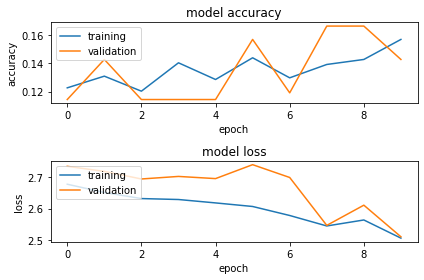

In [18]:
plt.figure()

# Summarize history for accuracy  
plt.subplot(211)
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper left')

# Summarize history for loss  
plt.subplot(212)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper left')
plt.tight_layout()
plt.show()

This model had a lot less overfitting compared to the previous model. However, the accuracy was about the same.

## Comparing Accuracy and Loss 
 

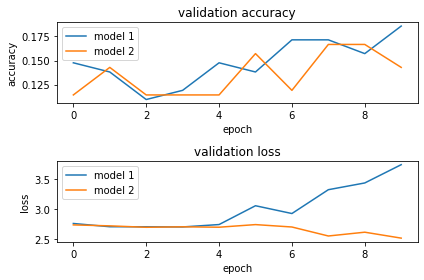

In [21]:
plt.figure()

plt.subplot(211)
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# Model 1 respresents the simple CNN 
# Model 2 represents the CNN that uses transfer learning from VGG16
plt.legend(['model 1', 'model 2'],loc='upper left')

plt.subplot(212)
plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.title('validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# Model 1 respresents the simple CNN 
# Model 2 represents the CNN that uses transfer learning from VGG16
plt.legend(['model 1', 'model 2'],loc='upper left')
plt.tight_layout()
plt.show()

Despite having slightly lower validation accuracy, model 2 had much lower validation loss than model 1.